### Imports

In [26]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
import os

# **Data Cleaning**

### Load datasets

In [27]:
data_files = os.path.join(os.getcwd(), "data") #Alter accordingly if needed

accounts_df = pd.read_csv(os.path.join(data_files, "accounts.csv"))
products_df = pd.read_csv(os.path.join(data_files, "products.csv"))
sales_pipeline_df = pd.read_csv(os.path.join(data_files, "sales_pipeline.csv"))
sales_teams_df = pd.read_csv(os.path.join(data_files, "sales_teams.csv"))

### Remove duplicates



In [28]:
accounts_df.drop_duplicates(inplace=True)
products_df.drop_duplicates(inplace=True)
sales_pipeline_df.drop_duplicates(inplace=True)
sales_teams_df.drop_duplicates(inplace=True)

Fixing this issue: Sales pipeline product column is "GTXPro" without a space, while product's product has "GTX Pro" with space.

In [29]:
sales_pipeline_df['product'] = sales_pipeline_df['product'].replace("GTXPro", "GTX Pro")

In [30]:
#Verifying that worked as intended
print(sales_pipeline_df['product'].unique())

['GTX Plus Basic' 'GTX Pro' 'MG Special' 'GTX Basic' 'MG Advanced'
 'GTX Plus Pro' 'GTK 500']


### Merge datasets

In [31]:
merged_df = (
  sales_pipeline_df
  .merge(sales_teams_df, on="sales_agent", how="left")
  .merge(products_df, on="product", how="left")
  .merge(accounts_df, on="account", how="left")
)
print(merged_df.shape)
merged_df.head(10)

(8800, 18)


,opportunity_id,sales_agent,product,account,deal_stage,engage_date,close_date,close_value,manager,regional_office,series,sales_price,sector,year_established,revenue,employees,office_location,subsidiary_of
0,1C1I7A6R,Moses Frase,GTX Plus Basic,Cancity,Won,2016-10-20,2017-03-01,1054.0,Dustin Brinkmann,Central,GTX,1096,retail,2001.0,718.62,2448.0,United States,NaN
1,Z063OYW0,Darcel Schlecht,GTX Pro,Isdom,Won,2016-10-25,2017-03-11,4514.0,Melvin Marxen,Central,GTX,4821,medical,2002.0,3178.24,4540.0,United States,NaN
2,EC4QE1BX,Darcel Schlecht,MG Special,Cancity,Won,2016-10-25,2017-03-07,50.0,Melvin Marxen,Central,MG,55,retail,2001.0,718.62,2448.0,United States,NaN
3,MV1LWRNH,Moses Frase,GTX Basic,Codehow,Won,2016-10-25,2017-03-09,588.0,Dustin Brinkmann,Central,GTX,550,software,1998.0,2714.90,2641.0,United States,Acme Corporation
4,PE84CX4O,Zane Levy,GTX Basic,Hatfan,Won,2016-10-25,2017-03-02,517.0,Summer Sewald,West,GTX,550,services,1982.0,792.46,1299.0,United States,NaN
5,ZNBS69V1,Anna Snelling,MG Special,Ron-tech,Won,2016-10-29,2017-03-01,49.0,Dustin Brinkmann,Central,MG,55,medical,1992.0,3922.42,6837.0,United States,NaN
6,9ME3374G,Vicki Laflamme,MG Special,J-Texon,Won,2016-10-30,2017-03-02,57.0,Celia Rouche,West,MG,55,retail,1989.0,1388.67,3583.0,United States,NaN
7,7GN8Q4LL,Markita Hansen,GTX Basic,Cheers,Won,2016-11-01,2017-03-07,601.0,Celia Rouche,West,GTX,550,entertainment,1993.0,4269.90,6472.0,United States,Massive Dynamic
8,OLK9LKZB,Niesha Huffines,GTX Plus Basic,Zumgoity,Won,2016-11-01,2017-03-03,1026.0,Melvin Marxen,Central,GTX,1096,medical,1984.0,441.08,1210.0,United States,NaN
9,HAXMC4IX,James Ascencio,MG Advanced,NaN,Engaging,2016-11-03,NaN,NaN,Summer Sewald,West,MG,3393,NaN,NaN,NaN,NaN,NaN,NaN


### Handle missing values with mode/median imputation

In [32]:
categorical_columns = merged_df.select_dtypes(include="object").columns
numerical_columns = merged_df.select_dtypes(include="float64").columns

#Handling missing values in categorical variables with mode imputation
for col in categorical_columns:
  merged_df[col]=merged_df[col].fillna(merged_df[col].mode()[0])

#Handling missing values in numerical variables with median imputation
for col in numerical_columns:
  if col not in["close_value", "close_date", "engage_date"] : # close_value should not be replaced with fake values, since a null value means the deal hasn't been closed yet.
    merged_df[col] = merged_df[col].fillna(merged_df[col].median())

### Convert date columns to proper datetime format

In [33]:
merged_df["engage_date"]=pd.to_datetime(merged_df["engage_date"], errors="coerce")
merged_df["close_date"]=pd.to_datetime(merged_df["close_date"], errors="coerce")

### Standardize categorical values

In [34]:
for col in categorical_columns:
    merged_df[col] = merged_df[col].astype(str).str.strip().str.upper()

### Handling outliers

In [35]:
for col in numerical_columns:
  if col != "close_value": #close_value should not be replaced with fake values, since a null value means the deal hasn't been closed yet.
    Q1 = merged_df[col].quantile(0.25)
    Q3 = merged_df[col].quantile(0.75)
    IQR = Q3-Q1

    lower_side = Q1 -1.5 *IQR
    upper_side = Q3 +1.5 * IQR

    merged_df[col]=merged_df[col].clip(lower=lower_side, upper=upper_side)


In [36]:
cols_to_log = ["close_value", "revenue", "employees"]

for col in cols_to_log:
    merged_df[col + "_log"] = np.log1p(merged_df[col])

merged_df[["close_value", "close_value_log",
           "revenue", "revenue_log",
           "employees", "employees_log"]].head()

,close_value,close_value_log,revenue,revenue_log,employees,employees_log
0,1054.0,6.961296,718.62,6.578723,2448.0,7.803435
1,4514.0,8.415160,3178.24,8.064397,4540.0,8.420903
2,50.0,3.931826,718.62,6.578723,2448.0,7.803435
3,588.0,6.378426,2714.90,7.906879,2641.0,7.879291
4,517.0,6.249975,792.46,6.676403,1299.0,7.170120


# **Data Transformation**

Encode categorical variables

In [37]:
label_enc = LabelEncoder()
cols_to_label_encode = ["sales_agent", "account", "office_location"] # only label encode columns that have too many unique values to one-hot encode

for col in cols_to_label_encode:
    merged_df[col] = label_enc.fit_transform(merged_df[col])
    
# Columns we will one-hot encode
cols_to_one_hot = ["product", "manager", "regional_office", "series", "sector", "subsidiary_of", "deal_stage"]

# Perform one-hot encoding using pandas.get_dummies
merged_df = pd.get_dummies(merged_df, columns=cols_to_one_hot, drop_first=False)

Standardize numerical variables

In [38]:
# Standardize numbers -> only sales price
scaler = StandardScaler()
merged_df["sales_price_scaled"] = scaler.fit_transform(merged_df[["sales_price"]])

Handling Year Established -> Binning into decade and then one-hot encoding

In [39]:
# Bin years into decades (e.g. 1996 → 1990s)
merged_df["year_established_decade"] = (
    (merged_df["year_established"] // 10).astype(int) * 10
).astype(str) + "s"

# One-hot encode the binned decades
merged_df = pd.get_dummies(
    merged_df,
    columns=["year_established_decade"],
    prefix="decade",
    prefix_sep="_"
)

Filtering/dropping unnecessary columns

In [40]:
# opportunity_id is the only column safe to remove because it is a unique identifier and has no predictive or explanatory value for the model.
merged_df.drop(columns=["opportunity_id"], inplace=True)

# **Verifying**

In [41]:
merged_df.isnull().sum()

sales_agent                          0
account                              0
engage_date                          0
close_date                           0
close_value                       2089
sales_price                          0
year_established                     0
revenue                              0
employees                            0
office_location                      0
close_value_log                   2089
revenue_log                          0
employees_log                        0
product_GTK 500                      0
product_GTX BASIC                    0
product_GTX PLUS BASIC               0
product_GTX PLUS PRO                 0
product_GTX PRO                      0
product_MG ADVANCED                  0
product_MG SPECIAL                   0
manager_CARA LOSCH                   0
manager_CELIA ROUCHE                 0
manager_DUSTIN BRINKMANN             0
manager_MELVIN MARXEN                0
manager_ROCCO NEUBERT                0
manager_SUMMER SEWALD    

In [42]:
merged_df.shape

(8800, 59)

In [43]:
merged_df.head(10)

,sales_agent,account,engage_date,close_date,close_value,sales_price,year_established,revenue,employees,office_location,...,deal_stage_ENGAGING,deal_stage_LOST,deal_stage_PROSPECTING,deal_stage_WON,sales_price_scaled,decade_1970s,decade_1980s,decade_1990s,decade_2000s,decade_2010s
0,20,8,2016-10-20,2017-03-01,1054.0,1096,2001.0,718.62,2448.0,14,...,False,False,False,True,-0.488043,False,False,False,True,False
1,6,38,2016-10-25,2017-03-11,4514.0,4821,2002.0,3178.24,4540.0,14,...,False,False,False,True,0.928795,False,False,False,True,False
2,6,8,2016-10-25,2017-03-07,50.0,55,2001.0,718.62,2448.0,14,...,False,False,False,True,-0.883996,False,False,False,True,False
3,20,10,2016-10-25,2017-03-09,588.0,550,1998.0,2714.90,2641.0,14,...,False,False,False,True,-0.695719,False,False,True,False,False
4,29,34,2016-10-25,2017-03-02,517.0,550,1982.0,792.46,1299.0,14,...,False,False,False,True,-0.695719,False,True,False,False,False
5,0,58,2016-10-29,2017-03-01,49.0,55,1992.0,3922.42,6837.0,14,...,False,False,False,True,-0.883996,False,False,True,False,False
6,26,40,2016-10-30,2017-03-02,57.0,55,1989.0,1388.67,3583.0,14,...,False,False,False,True,-0.883996,False,True,False,False,False
7,17,9,2016-11-01,2017-03-07,601.0,550,1993.0,4269.90,6472.0,14,...,False,False,False,True,-0.695719,False,False,True,False,False
8,21,84,2016-11-01,2017-03-03,1026.0,1096,1984.0,441.08,1210.0,14,...,False,False,False,True,-0.488043,False,True,False,False,False
9,12,35,2016-11-03,2017-05-22,NaN,3393,1995.0,1698.20,3492.0,14,...,True,False,False,False,0.385642,False,False,True,False,False


In [44]:
merged_df.columns

Index(['sales_agent', 'account', 'engage_date', 'close_date', 'close_value',
       'sales_price', 'year_established', 'revenue', 'employees',
       'office_location', 'close_value_log', 'revenue_log', 'employees_log',
       'product_GTK 500', 'product_GTX BASIC', 'product_GTX PLUS BASIC',
       'product_GTX PLUS PRO', 'product_GTX PRO', 'product_MG ADVANCED',
       'product_MG SPECIAL', 'manager_CARA LOSCH', 'manager_CELIA ROUCHE',
       'manager_DUSTIN BRINKMANN', 'manager_MELVIN MARXEN',
       'manager_ROCCO NEUBERT', 'manager_SUMMER SEWALD',
       'regional_office_CENTRAL', 'regional_office_EAST',
       'regional_office_WEST', 'series_GTK', 'series_GTX', 'series_MG',
       'sector_EMPLOYMENT', 'sector_ENTERTAINMENT', 'sector_FINANCE',
       'sector_MARKETING', 'sector_MEDICAL', 'sector_RETAIL',
       'sector_SERVICES', 'sector_SOFTWARE', 'sector_TECHNOLGY',
       'sector_TELECOMMUNICATIONS', 'subsidiary_of_ACME CORPORATION',
       'subsidiary_of_BUBBA GUMP', 'subsidiar

### Task 5: EDA

In [47]:
merged_df.describe(include='all')

,sales_agent,account,engage_date,close_date,close_value,sales_price,year_established,revenue,employees,office_location,...,deal_stage_ENGAGING,deal_stage_LOST,deal_stage_PROSPECTING,deal_stage_WON,sales_price_scaled,decade_1970s,decade_1980s,decade_1990s,decade_2000s,decade_2010s
count,8800.000000,8800.000000,8800,8800,6711.000000,8800.000000,8800.000000,8800.000000,8800.000000,8800.000000,...,8800,8800,8800,8800,8.800000e+03,8800,8800,8800,8800,8800
unique,NaN,NaN,421,306,NaN,NaN,NaN,NaN,NaN,NaN,...,2,2,2,2,NaN,2,2,2,2,2
top,NaN,NaN,2017-07-22,2017-05-22,NaN,NaN,NaN,NaN,NaN,NaN,...,False,False,False,False,NaN,False,False,False,False,False
freq,NaN,NaN,566,2130,NaN,NaN,NaN,NaN,NaN,NaN,...,7211,6327,8300,4562,NaN,8725,6680,4545,7097,8153
mean,13.897500,39.986591,NaN,NaN,1490.915512,2379.109659,1995.366705,2106.799017,4640.427045,12.954091,...,NaN,NaN,NaN,NaN,-6.459479e-17,NaN,NaN,NaN,NaN,NaN
std,8.678309,21.886514,NaN,NaN,2320.670773,2629.243384,8.317020,1740.756718,4089.152878,2.930328,...,NaN,NaN,NaN,NaN,1.000057e+00,NaN,NaN,NaN,NaN,NaN
min,0.000000,0.000000,NaN,NaN,0.000000,55.000000,1979.000000,4.540000,9.000000,0.000000,...,NaN,NaN,NaN,NaN,-8.839964e-01,NaN,NaN,NaN,NaN,NaN
25%,6.000000,24.000000,NaN,NaN,0.000000,550.000000,1990.000000,718.620000,1588.000000,14.000000,...,NaN,NaN,NaN,NaN,-6.957186e-01,NaN,NaN,NaN,NaN,NaN
50%,14.000000,35.000000,NaN,NaN,472.000000,1096.000000,1995.000000,1698.200000,3492.000000,14.000000,...,NaN,NaN,NaN,NaN,-4.880425e-01,NaN,NaN,NaN,NaN,NaN
75%,21.000000,58.000000,NaN,NaN,3225.000000,4821.000000,2000.000000,2819.500000,6472.000000,14.000000,...,NaN,NaN,NaN,NaN,9.287954e-01,NaN,NaN,NaN,NaN,NaN


/var/folders/f3/htg9w8x94td7_gdj749_7wbm0000gn/T/ipykernel_19485/2913053177.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=corr, y=corr.index, palette="coolwarm")


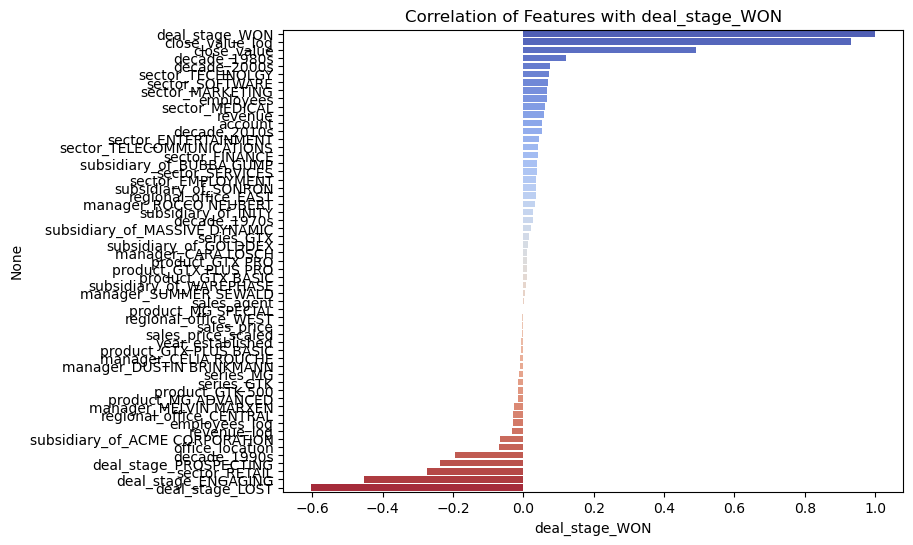

In [52]:
import matplotlib.pyplot as plt
target = "deal_stage_WON"   # replace with your actual target column
corr = merged_df.corr(numeric_only=True)[target].sort_values(ascending=False)

plt.figure(figsize=(8,6))
sns.barplot(x=corr, y=corr.index, palette="coolwarm")
plt.title(f"Correlation of Features with {target}")
plt.show()

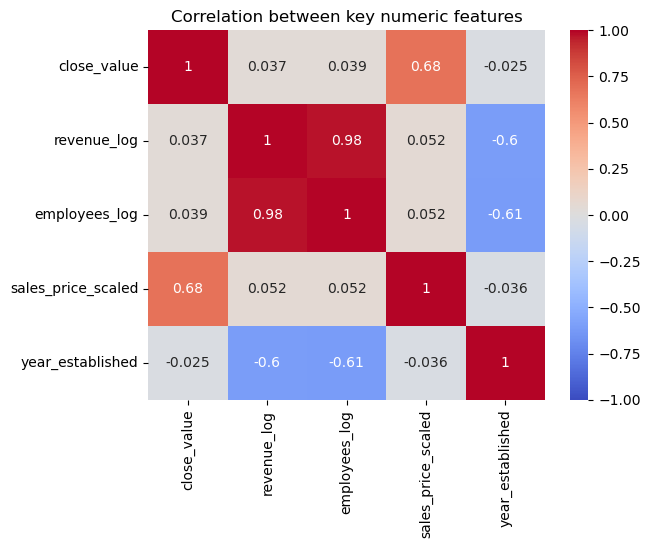

In [55]:
import seaborn as sns
keep = ['close_value','revenue_log','employees_log','sales_price_scaled',
        'year_established']  # adjust as needed
sub = merged_df[ [c for c in keep if c in merged_df.columns] ].select_dtypes(include=[np.number])
sns.heatmap(sub.corr(), annot=True, vmin=-1, vmax=1, cmap='coolwarm')
plt.title('Correlation between key numeric features')
plt.show()